# Gradient method for Spatial Transcriptomics
This notebook implements the 2D HSSVD Gradient estimation method and uses it on the VisiumHD 10x Spatial Transcriptomics dataset. 

# Loading Required Packages and Helper Functions
If you would like to use Cuda, set gpu = True. Otherwise set gpu = False. 

Step 1: Run the preliminary cells to load the data and create the HSSVD Gradient method.

Step 2: Run the execution cells to fit the HSSVD Gradient method on the data.

Step 3: Execute the cells to create the desired plots.

# Step 1: Loading data and the method

In [1]:
import os
import numpy as np
import pandas as pd
import torch
gpu = True
n_replicates = 2

import os, time, gc, math, urllib.request, statistics
import torch, gpytorch, numpy as np, pandas as pd, matplotlib, psutil
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
from scipy.io import loadmat
from math import floor
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy

print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(psutil.__version__)
print(gpytorch.__version__)


def get_mem():
    return psutil.Process(os.getpid()).memory_info().rss




gpu = torch.cuda.is_available()
smoke_test = ('CI' in os.environ)

coords_df = pd.read_csv('Data/coordinates.csv')
expr_df_mbp = pd.read_csv('Data/Mbp.csv')
expr_df_pcp4 = pd.read_csv('Data/Pcp4.csv')

all_x = torch.tensor(coords_df.values, dtype=torch.float32).contiguous()
all_y_mbp = torch.tensor(expr_df_mbp.iloc[:, 0].values, dtype=torch.float32).contiguous()
all_y_pcp4 = torch.tensor(expr_df_pcp4.iloc[:, 0].values, dtype=torch.float32).contiguous()


import torch
import numpy as np

def splitter(x_cpu, y_cpu, n_train=80000, n_test=20000, random_state=42, move_to_gpu=True):
    assert x_cpu.shape[0] == y_cpu.shape[0], "Mismatch in number of samples"
    total_samples = x_cpu.shape[0]
    assert n_train + n_test <= total_samples, "Not enough samples to split"
    rng = np.random.default_rng(seed=random_state)
    indices = rng.permutation(total_samples)
    train_idx = indices[:n_train]
    test_idx  = indices[n_train:n_train + n_test]

    train_x = x_cpu[train_idx].contiguous()
    train_y = y_cpu[train_idx].contiguous()
    test_x  = x_cpu[test_idx].contiguous()
    test_y  = y_cpu[test_idx].contiguous()

    if move_to_gpu and torch.cuda.is_available():
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        test_x = test_x.cuda()
        test_y = test_y.cuda()

    return train_x, train_y, test_x, test_y




2.6.0+cu118
1.26.4
3.9.2
5.9.0
1.13


This cell loads the HSSVD for Gradient estimation.

In [2]:
import torch
import torch.optim as optim

def phifunc(m, x):
    device = x.device
    dtype = x.dtype
    n = x.shape[0]
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    sin1 = torch.sin(torch.pi * freq.unsqueeze(1) * x[:, 0].unsqueeze(0))
    sin2 = torch.sin(torch.pi * freq.unsqueeze(1) * x[:, 1].unsqueeze(0))
    sin1_t = sin1.transpose(0, 1)
    sin2_t = sin2.transpose(0, 1)
    phi = (sin1_t.unsqueeze(2) * sin2_t.unsqueeze(1)).reshape(n, -1)
    return phi


def lambdafunc(m, eps, beta):
    device = eps.device
    dtype = eps.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    I2 = (freq.unsqueeze(1)**2 + freq.unsqueeze(0)**2)
    lam = ((torch.pi**2) * I2 + eps**2)**(-beta)
    lam = lam.reshape(-1)
    lam = lam / torch.max(lam)
    return lam


def gradphifunc(m, x):
    device = x.device
    dtype = x.dtype
    n = x.shape[0]

    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    pi_freq = torch.pi * freq

    sin1 = torch.sin(pi_freq[None, :] * x[:, 0:1])  # (n, m)
    sin2 = torch.sin(pi_freq[None, :] * x[:, 1:2])  # (n, m)
    cos1 = torch.cos(pi_freq[None, :] * x[:, 0:1])  # (n, m)
    cos2 = torch.cos(pi_freq[None, :] * x[:, 1:2])  # (n, m)

    dphi_dx1 = (pi_freq[None, :, None] * cos1[:, :, None]) * sin2[:, None, :]  # (n, m, m)
    dphi_dx2 = (pi_freq[None, None, :] * sin1[:, :, None]) * cos2[:, None, :]  # (n, m, m)
    dphi_dx1 = dphi_dx1.reshape(n, -1)
    dphi_dx2 = dphi_dx2.reshape(n, -1)
    grad_phi = torch.cat([dphi_dx1, dphi_dx2], dim=0)
    return grad_phi * 2



def hssvd_predict_2d_dx(x, y, x_new, init=torch.tensor([0.0, 0.0]), m=30, beta=1, 
                     train=True, lr=0.01, max_iter=1000, tol=1e-5):
    device = x.device
    dtype = x.dtype
    #print(device)
    #print(dtype)
    init = init.to(device=device, dtype=dtype)
    n = x.shape[0]
    Phi = phifunc(m, x)
    MM = Phi.shape[1]
    phi_T_phi = Phi.t() @ Phi
    phi_T_y = Phi.t() @ y
    sum_y2 = torch.sum(y**2)
    
    def nlik(log_params):
        eps = torch.exp(log_params[0])
        s2  = torch.exp(log_params[1])
        Lambda = lambdafunc(m, eps, beta)
        A = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
        L = torch.linalg.cholesky(A)
        sol = torch.cholesky_solve(phi_T_y.unsqueeze(1), L).squeeze(1)
        t1 = (sum_y2 - (phi_T_y @ sol)) / s2
        logdetA = 2 * torch.sum(torch.log(torch.diag(L)))
        t2 = (n - m) * torch.log(s2) + logdetA
        t3 = torch.sum(torch.log((Lambda)))
        return t1 + t2 + t3
    
    
    
    if train:
        log_params = init.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([log_params], lr=lr)
        prev_loss = None
        for iter_ in range(max_iter):
            optimizer.zero_grad()
            loss = nlik(log_params)
            loss.backward()
            optimizer.step()
            print(f"Iter {iter_}: estimate = {log_params.data}, loss = {loss.item():.4f}", end="\r")
            if prev_loss is not None and torch.abs(loss - prev_loss) < tol*n:
                print(f"\nConverged after {iter_} iterations")
                break
            prev_loss = loss.item()
        out = log_params.detach()
    else:
        out = init

    
    eps  = torch.exp(out[0])
    s2   = torch.exp(out[1])
    Lambda = lambdafunc(m, eps, beta)
    A_final = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
    L_final = torch.linalg.cholesky(A_final)
    sol_final = torch.cholesky_solve(phi_T_y.unsqueeze(1), L_final).squeeze(1)
    K_inv_y = (1.0 / s2) * (y - Phi @ sol_final)
    Phi_new = phifunc(m, x_new)
    y_new = Phi_new @ (torch.diag(Lambda) @ (Phi.t() @ K_inv_y))
    w = torch.diag(Lambda) @ (Phi.T @ K_inv_y)

    gradPhi_new = gradphifunc(m, x_new)
    y_grad = gradPhi_new @ w
    return y_grad


# Step 2: Execute the method
The following cell executes the HSSVD method to predict the mean expression and the gradient of the expression.

In [3]:
init = torch.tensor([0.0, 0.0], dtype=torch.float32)
m = 60
beta = 1.5
lr = 0.1
num_repeats = 10

train_x, train_y, test_x, test_y = splitter(all_x, all_y_mbp, n_train=160000, n_test=80000, random_state=1)


import pandas as pd
import matplotlib.pyplot as plt

init = torch.tensor([0.0, 0.0], dtype=torch.float32)
y_grad = hssvd_predict_2d_dx(train_x.squeeze(), train_y.squeeze(), test_x.squeeze(), init=init, m=m, beta=beta, train=True, lr=lr)


import pandas as pd
import matplotlib.pyplot as plt

y_grad.shape

n_test = test_x.shape[0]
dx = y_grad[:n_test]
dy = y_grad[n_test:]

grad_norm = torch.sqrt(dx**2 + dy**2)




Iter 45: estimate = tensor([ 1.3926, -0.3971], device='cuda:0'), loss = 103786.9531
Converged after 45 iterations


# Step 3: Plotting
This cell plots the Raw observations and the predicted gradient for the Mbp gene over the slide.

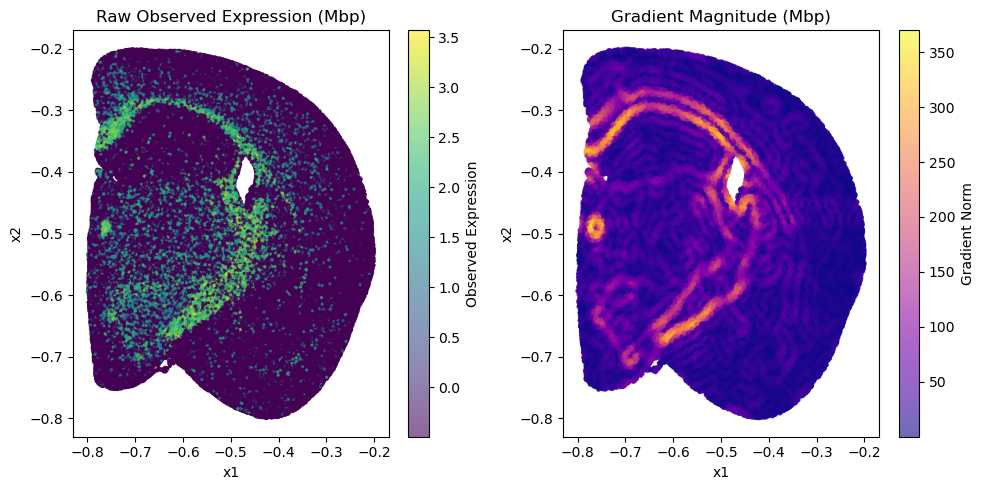

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Raw Observed Expression (Mbp)")
axs[0].scatter(-train_x[:, 0].cpu(), -train_x[:, 1].cpu(), c=train_y.cpu(), cmap='viridis', s=2, alpha=0.6)
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
cbar0 = fig.colorbar(axs[0].collections[0], ax=axs[0])
cbar0.set_label("Observed Expression")

axs[1].set_title("Gradient Magnitude (Mbp)")
axs[1].scatter(-test_x[:, 0].cpu(), -test_x[:, 1].cpu(), c=grad_norm.cpu(), cmap='plasma', s=5, alpha=0.6)
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
cbar2 = fig.colorbar(axs[1].collections[0], ax=axs[1])
cbar2.set_label(r"Gradient Norm")

plt.tight_layout()

fig.savefig("Figures/Mbp.png", dpi=600, bbox_inches='tight')

plt.show()



This cell plots the Raw observations and the predicted gradient for the Mbp gene over the slide.

Iter 36: estimate = tensor([ 0.9829, -0.3806], device='cuda:0'), loss = 101257.0625
Converged after 36 iterations


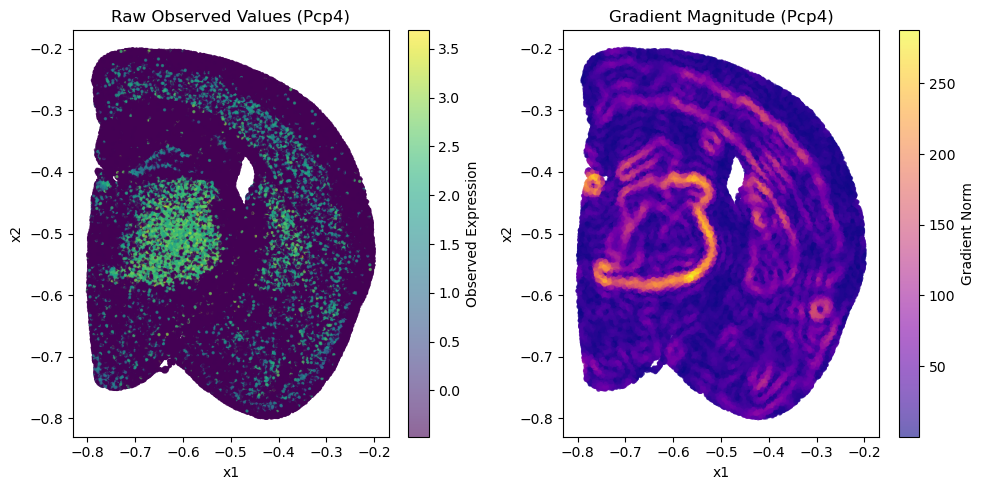

In [5]:
init = torch.tensor([0.0, 0.0], dtype=torch.float32)
m = 60
beta = 1.5
lr = 0.1
num_repeats = 10

train_x, train_y, test_x, test_y = splitter(all_x, all_y_pcp4, n_train=160000, n_test=80000, random_state=1)

init = torch.tensor([0.0, 0.0], dtype=torch.float32)
y_grad = hssvd_predict_2d_dx(train_x.squeeze(), train_y.squeeze(), test_x.squeeze(), init=init, m=m, beta=beta, train=True, lr=lr)


y_grad.shape
n_test = test_x.shape[0]
dx = y_grad[:n_test]
dy = y_grad[n_test:]

grad_norm = torch.sqrt(dx**2 + dy**2)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].set_title("Raw Observed Values (Pcp4)")
axs[0].scatter(-train_x[:, 0].cpu(), -train_x[:, 1].cpu(), c=train_y.cpu(), cmap='viridis', s=2, alpha=0.6)
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
cbar0 = fig.colorbar(axs[0].collections[0], ax=axs[0])
cbar0.set_label("Observed Expression")


axs[1].set_title("Gradient Magnitude (Pcp4)")
axs[1].scatter(-test_x[:, 0].cpu(), -test_x[:, 1].cpu(), c=grad_norm.cpu(), cmap='plasma', s=5, alpha=0.6)
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
cbar2 = fig.colorbar(axs[1].collections[0], ax=axs[1])
cbar2.set_label(r"Gradient Norm")

plt.tight_layout()

fig.savefig("Figures/Pcp4.png", dpi=600, bbox_inches='tight')

plt.show()
